In [1]:
from SSVAERegressor import *
import numpy as np
import util
from sklearn.preprocessing import  *
import matplotlib.pyplot as plt

# MNIST data

In this notebook, we implement a regression version of semi-supervised VAE (M2) model.    
We are regressing 784 by 1 image vector against labels that range over (0-9).  
We assume Gaussian(0,1) prior on y so we will normalize the output labels accordingly.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000,784)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

train_unlabeled = util.BatchFeeder(X[index[:53000]], np.zeros((53000, 1)), 128)
train_labeled = util.BatchFeeder(X[index[53000:54000]], scale(np.argmax(Y[index[53000:54000]], axis=1).reshape((1000, 1))), 128)
test_data = (X[index[54000:]], scale(np.argmax(Y[index[54000:]], axis=1).reshape((1000, 1))))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[-0.85190898]


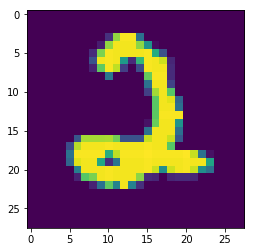

In [4]:
data = train_labeled.next()
print data[1][0]
plt.figure()
plt.imshow(data[0][0].reshape((28,28)))
plt.show()

# Training SSVAERegressor

Implementation of SSVAERegressor can be found under SSVAERegressor.py

In [5]:
model = SSVAERegressor(input_dim=784, vae_dims=[256, 64], reg_dims=[256, 64], latent_dim=2, prediction_dim=1)

Epoch: [99/100] loss: 300.87, kld: 10.24, rec: 288.65, logdensity(labeled): 0.74, kld(unlabeled): 2.05, mse: 0.19030

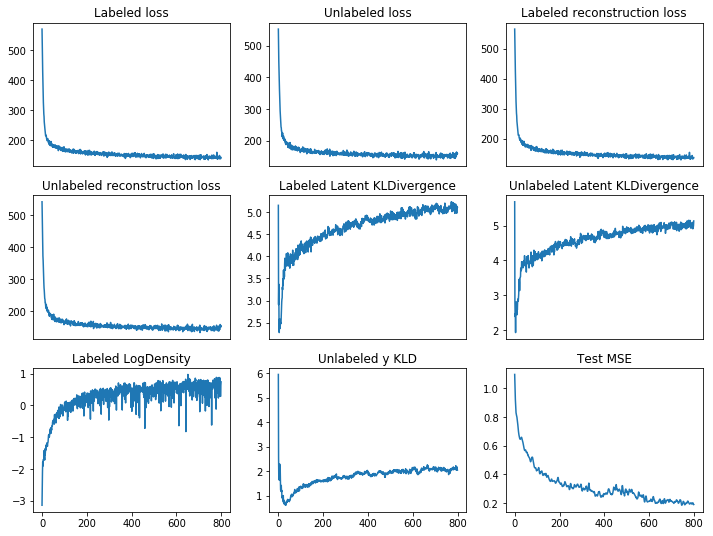

In [6]:
model.train(train_labeled, train_unlabeled, epochs=100, valid=test_data)

In [9]:
model.save("test")

In [8]:
model.load("test")

INFO:tensorflow:Restoring parameters from test/model.ckpt


# Logistic regression

We compare against logistic regression and get obviously better result with M2

In [16]:
import sklearn.linear_model as lm
model2 = lm.Ridge()
model2.fit(X[index[53000:54000]], scale(np.argmax(Y[index[53000:54000]], axis=1)))
pred = model2.predict(test_data[0])
print "MSE with logistic regression:", np.mean(np.square(test_data[1]-pred))

MSE with logistic regression: 1.95558577509


# Only Multiple Layer Perceptrons

We compare against MLP with the same architecture as regressor within the M2 model. We get better result

In [11]:
# Adapted from M2

class MLP():
    def __init__(self, verbose):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Tracking data
        self.loss = {}
        self.record = {}
        
        # Define some parameters
        self.e = 0
        self.verbose = verbose
        
        # Define dimensionality
        self.input_dim = 784
        self.dims = [256, 64]
        self.prediction_dim = 1
        
        # Building the graph
        self.built = False
        self.sesh = tf.Session()
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter('logs', self.sesh.graph)
        
    def build(self):
        # Placeholders for input and dropout probs.
        if self.built:
            return -1
        else:
            self.built = True
            
        #####################
        # Building networks #
        #####################
        
        # Defining inputs
        x_in_labeled = tf.placeholder(tf.float32, shape=[None, self.input_dim], name="x_in_labeled")
        y = tf.placeholder(tf.float32, shape=[None, self.prediction_dim], name="y")
        
        # Building network q(y|x)
        pred = self.encoder(x_in_labeled,
                            output_dim=self.prediction_dim,
                            _is_train=True,
                            scope="regressor")
        
        
        #################
        # Defining loss #
        #################
        
        # Defining Loss for labeled data
        with tf.variable_scope("loss"):
            loss = tf.reduce_mean(tf.square(y-pred))
        
        ################
        # Optimization #
        ################
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optim = tf.train.AdamOptimizer().minimize(loss)
            
        #########################
        # Network for later use #
        #########################
        x_ = tf.placeholder(tf.float32, shape=[None, self.input_dim], name="x")
        # Building network q(y|x)
        pred_= self.encoder(x_, output_dim=self.prediction_dim, _is_train=False, scope="regressor", reuse=True)
            
        return dict(
            x_in_labeled = x_in_labeled,
            y = y,
            x_ = x_,
            pred_ = pred_,
            optim = optim,
            loss = loss
        )
        
    ###########
    # Encoder #
    ###########
    def encoder(self, _input, _is_train, output_dim, _fn=tf.nn.relu, scope="encoder", reuse=None):
        with tf.variable_scope(scope, reuse=reuse):
            net = _input
            for dim in self.dims:
                net = tf.contrib.slim.fully_connected(net, dim, activation_fn=tf.identity)
                if self.verbose: print net
                net = tf.contrib.layers.batch_norm(net, is_training=_is_train)
                net = _fn(net)
            
            mu = tf.contrib.slim.fully_connected(net, output_dim, activation_fn=tf.identity)
            if self.verbose: print mu
            return mu
   
    ############
    # Training #
    ############
    def train(self, X_labeled, epochs, valid=None):
        e = 0
        start_e = self.e
        while e < epochs:
            for i in range(X_labeled.batch_num):
                
                # Get data
                x_labeled, y = X_labeled.next()
                
                # Training with labeled data
                feed_dict = {self.ops["x_in_labeled"]: x_labeled,
                             self.ops["y"]: y}
                ops_to_run = [self.ops["loss"],
                              self.ops["optim"]]
                loss, _ = self.sesh.run(ops_to_run, feed_dict)
                
                # Use Validation
                if valid != None:
                    pred = self.predict(valid[0])
                    mse = np.mean(np.square(valid[1]-pred[:, 0]))
                    
                
                if valid!=None:
                    sys.stdout.write("\rEpoch: [%2d/%2d] loss: %.2f, mse: %.2f"
                                     %(self.e, start_e+epochs, loss, mse))
                else:
                    sys.stdout.write("\rEpoch: [%2d/%2d] loss: %.2f"
                                     %(self.e, start_e+epochs, loss))

            self.e+=1
            e+= 1
            
    ##############
    # Prediction #
    ##############
    def predict(self, x=None):
        return self.sesh.run(self.ops["pred_"], {self.ops["x_"]: x})

In [12]:
model3 = MLP(verbose=False)

In [13]:
model3.train(train_labeled, 100, test_data)

Epoch: [99/100] loss: 0.01, mse: 1.18